<a href="https://colab.research.google.com/github/Sidd-ctrl/iirs-isro_session/blob/main/ISRO_session1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Owner -Siddhant Pradhan

In [ ]:
import torch
import numpy as np

In [ ]:
data=[[1,2],[3,4]]
x_data= torch.tensor(data)

In [ ]:
x_data

tensor([[1, 2],
        [3, 4]])

In [ ]:
np_array= np.array(data)
x_np =torch.from_numpy(np_array)

In [ ]:
x_np

tensor([[1, 2],
        [3, 4]])

In [ ]:
! pip install torchgeo

Working with Data

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchgeo.datasets import EuroSAT100
import torch.nn.functional as F

In [ ]:
training_data= EuroSAT100(
    root="data",
    split="train",
    download=True,
)

100%|██████████| 7717354/7717354 [00:00<00:00, 77814040.05it/s]


100%|██████████| 1152/1152 [00:00<00:00, 1296789.64it/s]


100%|██████████| 383/383 [00:00<00:00, 422186.18it/s]


100%|██████████| 382/382 [00:00<00:00, 668428.92it/s]


In [ ]:
test_data= EuroSAT100(
    root="data",
    split='val',
    download= True,
)

EUROSET DATA SET , SENTENNIAL-2 DATA


In [ ]:
labels_map = {
    0: "Annual Crop",
    1: "Forest",
    2: "Herbaceous Vegetation",
    3: "Highway",
    4: "Industrial Buildings",
    5: "Pasture",
    6: "Permanent Crop",
    7: "Resisential Building",
    8: "River",
    9: "Sea & Lake",
}

In [ ]:
training_data[0]['image'].shape

torch.Size([13, 64, 64])

In [ ]:
len(training_data)

60

In [ ]:
import matplotlib.pyplot as plt

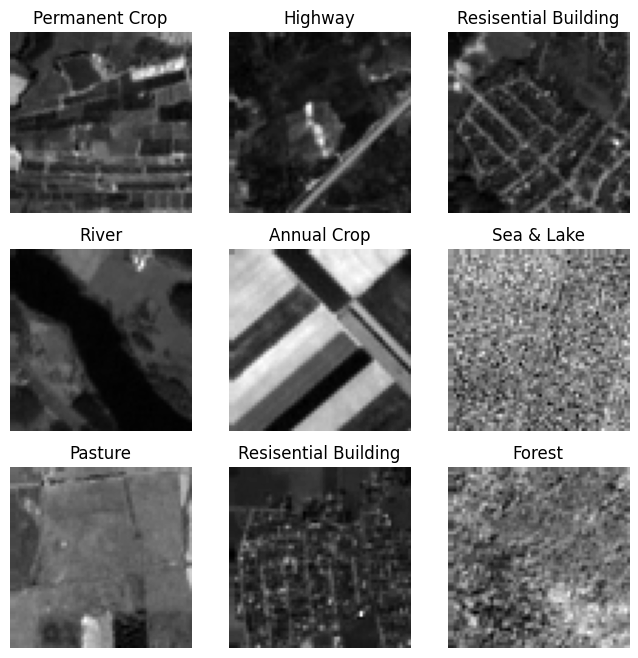

In [ ]:
figure = plt.figure(figsize=(8,8))
cols, rows= 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  data = training_data[sample_idx]
  img, label = data['image'], data['label'].item()
  figure.add_subplot(rows, cols , i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img[2], cmap="gray")
plt.show()

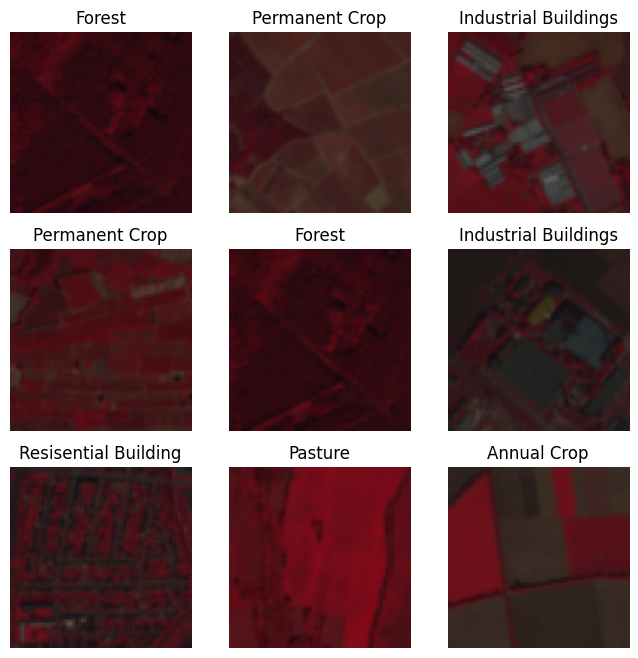

In [ ]:
figure = plt.figure(figsize=(8,8))
cols, rows =3,3
for i in range(1,cols*rows+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  data= training_data[sample_idx]
  img, label= data['image'],data['label'].item()
  img= torch.stack((img[7],img[3],img[2]), dim=0)
  img= torch.permute(img,(1,2,0))
  figure.add_subplot(rows,cols,i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img/10000.)
plt.show()

In [ ]:
batch_size=4

#create data loaders
train_dataLoader = DataLoader(training_data, batch_size=batch_size, shuffle= True)
test_dataLoader = DataLoader(test_data, batch_size=batch_size, shuffle= True)

for data in test_dataLoader:
  X= data['image']
  y= data['label']
  print(f"shape of X[N,C,H,W]: {X.shape}")
  print(f"shape of Y :{y.shape} {y.data}")
  break

shape of X[N,C,H,W]: torch.Size([4, 13, 64, 64])
shape of Y :torch.Size([4]) tensor([6, 1, 3, 5])


CREATING MODEL

In [ ]:
device=(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"using {device} device")

using cpu device


In [ ]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten= nn.Flatten()
    self.linear_relu_stack= nn.Sequential(
        nn.Linear(13 * 64 * 64, 512),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Linear(128,32),
        nn.ReLU(),
        nn.Linear(32,10),
    )

    def forward(self,x):
      x= self.flatten(x)
      logits= self.linear_relu_stack(x)
      return logits

In [ ]:
model= NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=53248, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=1e-4)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size= len(dataloader.dataset)
  model.train()
  for batch, (X,y) in enumerate(dataloader):
    X= img_data['image']
    y= img_data['label']
    X,y= X.to(device), y.to(device)
    pred= model(X)

    loss= loss_fn(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 4==0:
      loss, current= loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


In [ ]:
def test(dataloader , model , loss_fn):
  size= len(dataloader.dataset)
  num_batches= len(dataloader)
  model.eval()
  test_loss, correct= 0,0
  with torch.no_grad():
    for img_data in dataloader:
      X= img_data['image']
      y= img_data['label']
      X,y= X.to(device), y.to(device)
      pred= model(X)
      test_loss += loss_fn(pred,y).item()
      correct += (pred.argmax(1)==y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [ ]:
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs=10
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataLoader, model, loss_fn)
print("Done!")